Objectives of this prediction model are:
1. Build a model to predict Apartment Price
2. Evaluate all features in dataset for use in model
3. Create two deployments of trained model

**Machine Learning Workflow**
1. PREPARING DATA
    * Importing: `wrangle` function and list comprehension
    * Exploring: `Null values`, `high`-and `low-cardinality` (categorical features with too few or too many unique values), `leakage` (features giving information about target which shouldn't be there), `multicollinearity`
    * Splitting
2. BUILDING MODEL
    * Baselining
    * Iterating
    * Evaluating
3. COMMUNICATING RESULTS
    * Making `make_prediction` function
    * Interactive Dashboard Minimum Viable Product (MVP)

In [1]:
# importing libraries
from glob import glob

import pandas as pd
import seaborn as sns # For data visualisation
from category_encoders import OneHotEncoder
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact # For interactive dashboard

from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline


# 1. Preparing Data
## 1.1 Importing Data

In [2]:
# Using wrangle function to import files into Dataframe

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)

    # Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighbourhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    
    return df

In [3]:
# Using glob to get the files
files = glob('buenos-aires-real-estate-*.csv')
files

['buenos-aires-real-estate-1.csv',
 'buenos-aires-real-estate-2.csv',
 'buenos-aires-real-estate-3.csv',
 'buenos-aires-real-estate-4.csv',
 'buenos-aires-real-estate-5.csv']

**LIST COMPREHENSION** 
* a convenient way to avoid multiple lines of code when iteration is required through multiple files

In [4]:
frames = [wrangle(file) for file in files] # start with what needs to be iterated at the end

In [5]:
len(frames)

5

In [6]:
type(frames[0])

pandas.core.frame.DataFrame

In [7]:
frames[1].head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighbourhood
2,sell,apartment,215000.0,USD,3259916.00,215000.00,40.0,35.0,5375.000000,6142.857143,NaN,1.0,3500.0,http://recoleta.properati.com.ar/12j4v_venta_d...,-34.588993,-58.400133,Recoleta
9,sell,apartment,341550.0,USD,5178717.72,341550.00,NaN,90.0,NaN,3795.000000,8.0,2.0,NaN,http://recoleta.properati.com.ar/100t0_venta_d...,-34.588044,-58.398066,Recoleta
12,sell,apartment,1386000.0,ARS,1382153.13,91156.62,39.0,33.0,2337.349231,42000.000000,NaN,NaN,NaN,http://monserrat.properati.com.ar/t05l_venta_d...,-34.623320,-58.397461,Monserrat
13,sell,apartment,105000.0,USD,1592052.00,105000.00,NaN,33.0,NaN,3181.818182,1.0,1.0,NaN,http://belgrano.properati.com.ar/zsd5_venta_de...,-34.553897,-58.451939,Belgrano
17,sell,apartment,89681.0,USD,1359779.19,89681.00,46.0,39.0,1949.586957,2299.512821,NaN,1.0,1500.0,http://villa-del-parque.properati.com.ar/12q2f...,-34.628813,-58.472230,Villa del Parque


**Concatenating DataFrames**

In [8]:
df = pd.concat(frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  floor                       1900 non-null   float64
 11  rooms                       5286 non-null   float64
 12  expenses                    1739 non-null   object 
 13  properati_url               6582 

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighbourhood
0,sell,apartment,129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,-34.584651,-58.454693,Chacarita
1,sell,apartment,87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...,-34.638979,-58.500115,Villa Luro
2,sell,apartment,118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...,-34.615847,-58.459957,Caballito
3,sell,apartment,57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364,http://constitucion.properati.com.ar/k2f0_vent...,-34.625222,-58.382382,Constitución
4,sell,apartment,90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450,http://once.properati.com.ar/suwa_venta_depart...,-34.610610,-58.412511,Once


## 1.2 Exploring Data

1. **Removing missing/Null values NaN**
    * If a column has more than 50% null values, then it is better to drop it
    
2. **Low or High Cardinality Categorical Features**
    * Low cardinality features have mostly unchanging values over the dataset. They are also called constants. They are unrequired and can be removed    
        **NOTE: If there's only one category in a column, it won't provide any unique information to our model. At the other extreme, columns where nearly every row has its own category won't help our model in identifying useful trends in the data**

3. **Leakage**
    * Features that were created using our target or that would give our model information that it won't have access to when it's deployed. e.g. taking point-difference into consideration to predict win/loss probability
    
4. **Multicollinearity**
    * Features in the feature matrix that are highly correlated with each other. A good way to detect this is by using a heatmap
    * It is helpful when features are correlated to target vector. But when multiple features themselves are correlated, that can introduce a bias
    * Multicollinearity is not a problem which must be avoided everytime. It is only a problem in certain contexts which depend on how the model is intended to be used. 
        * If the model is only concerned with performance metrics then multicollinearity is **NOT** a problem
        * If the model explanability or interpretability is the issue, then multicollinearity **IS A PROBLEM**. If two features are highly correlated, the coefficients obtained after training the model can't be reliably attributed to individual features or the interaction between features.
    

In [9]:
# Checking null values and normalising to check the percentage of missing values
round(df.isnull().sum() / len(df),3)

operation                     0.000
property_type                 0.000
price                         0.000
currency                      0.000
price_aprox_local_currency    0.000
price_aprox_usd               0.000
surface_total_in_m2           0.278
surface_covered_in_m2         0.000
price_usd_per_m2              0.311
price_per_m2                  0.000
floor                         0.711
rooms                         0.197
expenses                      0.736
properati_url                 0.000
lat                           0.040
lon                           0.040
neighbourhood                 0.000
dtype: float64

It appears that floor and expenses columns have over 70% values missing. It is best to drop them

**Looking at categorical features in DataFrame and checking unique values for cardinality**

In [10]:
# Isolating columns with categorical values. Categorical data is datatype object
df.select_dtypes('object').head()

,operation,property_type,currency,expenses,properati_url,neighbourhood
0,sell,apartment,USD,NaN,http://chacarita.properati.com.ar/10qlv_venta_...,Chacarita
1,sell,apartment,USD,NaN,http://villa-luro.properati.com.ar/12m82_venta...,Villa Luro
2,sell,apartment,USD,NaN,http://caballito.properati.com.ar/11wqh_venta_...,Caballito
3,sell,apartment,USD,364,http://constitucion.properati.com.ar/k2f0_vent...,Constitución
4,sell,apartment,USD,450,http://once.properati.com.ar/suwa_venta_depart...,Once


In [11]:
# Checking unique entries in categorical features columns
df.select_dtypes('object').nunique()

operation           1
property_type       1
currency            2
expenses          354
properati_url    6582
neighbourhood      57
dtype: int64

1. It can be seen that operation and property types have only one unique value. This is an example of **Low-Cardinality categorical feature**. It is best to remove them from model because they won't have any special bearing on final model
2. Currency itself can be seen as Low Cardinality feature
3. Property url is a **High Cardinality feature**. Every property has unique url, which makes sense. But this feature is not good for a linear model. So it can be dropped as well. Since each entry is a unique value, it won't give any information about the Trend
4. Out of these categorical features, only Neighbourhood is worth incorporating in model. Others need to be dropped

**Removing Leaky Features from Dataframe**

In [12]:
# Checking leaky features in our Dataset
sorted(df.columns)

['currency',
 'expenses',
 'floor',
 'lat',
 'lon',
 'neighbourhood',
 'operation',
 'price',
 'price_aprox_local_currency',
 'price_aprox_usd',
 'price_per_m2',
 'price_usd_per_m2',
 'properati_url',
 'property_type',
 'rooms',
 'surface_covered_in_m2',
 'surface_total_in_m2']

1. Everything related to price must be removed from dataset for modeling because we are ultimately predicting price of the apartment
2. price','price_aprox_local_currency','price_per_m2','price_usd_per_m2' must be dropped to avoid leaky features from the apartment price prediction model
3. 'price_aprox_usd' is our Target so it can not be removed**

**Multicollinearity Heatmap**
Checking for highly correlated features

<AxesSubplot:>

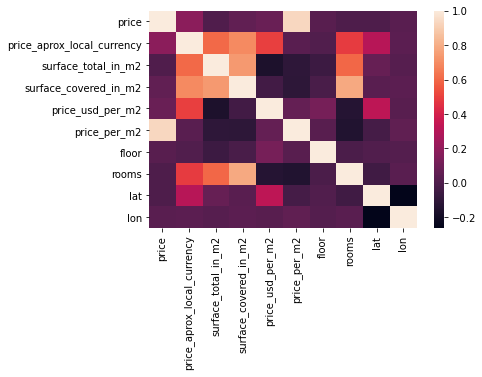

In [13]:
# Creating a correlation heatmap for numerical features. Removing price_aprox_usd because it is the target vector
corr = df.select_dtypes('number').drop(columns = 'price_aprox_usd').corr()
sns.heatmap(corr)

* The areas in purple and black don't appear to have any correlation
* We do see strong correlation between number of rooms in a house and the size of the house.
* We have 3 features which are highly correlated with each other, but we can only keep one out of 3 to avoid Multicollinearity issues.
* Further investigation needs to be performed to decide which feature to keep and which ones to let go

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   6582 non-null   object 
 1   property_type               6582 non-null   object 
 2   price                       6582 non-null   float64
 3   currency                    6582 non-null   object 
 4   price_aprox_local_currency  6582 non-null   float64
 5   price_aprox_usd             6582 non-null   float64
 6   surface_total_in_m2         4752 non-null   float64
 7   surface_covered_in_m2       6582 non-null   float64
 8   price_usd_per_m2            4536 non-null   float64
 9   price_per_m2                6582 non-null   float64
 10  floor                       1900 non-null   float64
 11  rooms                       5286 non-null   float64
 12  expenses                    1739 non-null   object 
 13  properati_url               6582 

It makes sense to choose `surface_covered_in_m2` column over `rooms` and `surface_total_in_m2` columns because it has less missing values

In [15]:
# modifying wrangle function to drop NaN columns, High-Low Cardinality features, Leakage, Multicollinearity

def wrangle(filepath):
    # Reading CSV file
    df = pd.read_csv(filepath)

    # Subsetting data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    df = df[mask_ba & mask_apt & mask_price]

    # Subsetting data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Splitting "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Getting place name
    df["neighbourhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Dropping features with high null counts
    df.drop(columns = ['floor', 'expenses'], inplace = True)
    
    # Dropping low= and high-cardinality categorical variables
    df.drop(columns = ['operation', 'property_type', 'currency', 'properati_url'], inplace = True)
    
    # Dropping leaky columns
    df.drop(
        columns = [
            'price',
            'price_aprox_local_currency',
            'price_per_m2',
            'price_usd_per_m2'
        ], 
        inplace = True
    )
    
    # Dropping columns with Multicollinearity issues
    df.drop(columns = ['surface_total_in_m2','rooms'], inplace = True)
    
    return df

In [16]:
files = glob('buenos-aires-real-estate-*.csv') # getting flies from glob
df = pd.concat([wrangle(file) for file in files], ignore_index=True) # concatenating files from an empty list
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighbourhood          6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighbourhood
0,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,118000.0,54.0,-34.615847,-58.459957,Caballito
3,57000.0,42.0,-34.625222,-58.382382,Constitución
4,90000.0,50.0,-34.610610,-58.412511,Once


**We are left with four useful features to build a model to predict apartment prices in Buenos Aires**

## 1.3 Splitting Data

In [17]:
target = "price_aprox_usd"
features = ['surface_covered_in_m2','lat','lon','neighbourhood']
X_train = df[features]
y_train = df[target]

# 2. Building Model
## 2.1 Baselining

In [18]:
y_mean = round(y_train.mean(), 2)
y_pred_baseline = [y_mean] * len(y_train)
print('Mean Apt. Price:', y_mean)
print('Baseline MAE:', round(mean_absolute_error(y_train, y_pred_baseline), 2))

Mean Apt. Price: 132383.84
Baseline MAE: 44860.11


## 2.2 Iterating

In [19]:
# Instantiating model with onehotencoder, simpleimputer and Ridge Regression Predictor components
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)

# Fitting model to training data
model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighbourhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

## 2.3 Evaluating

In [20]:
# Checking how the model performed on training data
y_pred_training = model.predict(X_train)
print('Training MAE:', round(mean_absolute_error(y_train, y_pred_training), 2))

Training MAE: 24207.11


### Running model on test data

In [21]:
X_test = pd.read_csv("buenos-aires-test-features.csv")
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    231122.403569
1    162572.942392
2     68477.949626
3     63521.438989
4    105694.463885
dtype: float64

# 3. Communicating Results

## 3.1 Deploying a Prediction Function
A function can be created which takes in 4 arguments: area, latitude, longitude, neighbourhood, to return a text string to the user

In [22]:
# Creating a dictionary to pass information from user into our model for prediction
def make_prediction(area, latitude, longitude, neighbourhood):
    data = {
        'surface_covered_in_m2': area,
        'lat': latitude,
        'lon': longitude,
        'neighbourhood': neighbourhood
    }
    
    # Putting the data gathered from user in a DataFrame for Prediction. Since it is only one row, therefore index is 0
    df = pd.DataFrame(data, index =[0]) 
    
    # Feeding data input by user into the model, rounding to 2 decimals and picking the first element in the list
    prediction = model.predict(df).round(2)[0]
    
    return f'Predicted Apartment Price: ${prediction}'

In [23]:
# Checking if the `make_prediction` function works
make_prediction(110, -34.60, -58.46, "Villa Crespo")

'Predicted Apartment Price: $250775.11'

## 3.1 Deploying an Interactive Dashboard Minimum Viable Product (MVP)
where a user can supply values and receive a prediction

In [25]:
interact(
    make_prediction,
    area = IntSlider(
        min = X_train["surface_covered_in_m2"].min(),
        max = X_train["surface_covered_in_m2"].max(),
        value = X_train["surface_covered_in_m2"].mean(),
    ),
    latitude = FloatSlider(
        min = X_train["lat"].min(),
        max = X_train["lat"].max(),
        step = 0.01,
        value = X_train["lat"].mean(),
    ),
    longitude = FloatSlider(
        min = X_train["lon"].min(),
        max = X_train["lon"].max(),
        step = 0.01,
        value = X_train["lon"].mean(),
    ),
    neighbourhood = Dropdown(options = sorted(X_train["neighbourhood"].unique())),
);

interactive(children=(IntSlider(value=53, description='area', max=101, min=30), FloatSlider(value=-34.59890626…

**Scope for Further Improvements**
1. Latitude and Longitude sliders are currently moving independently of Neighbourhood. Ideally, only those coordinates should be allowed to choose which fall within a particular Neighbourhood
2. A visualisation like a map would also be helpful to see how prices are changing across the city